In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB
None
              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0

/Users/seein/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seein/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seein/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seein/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

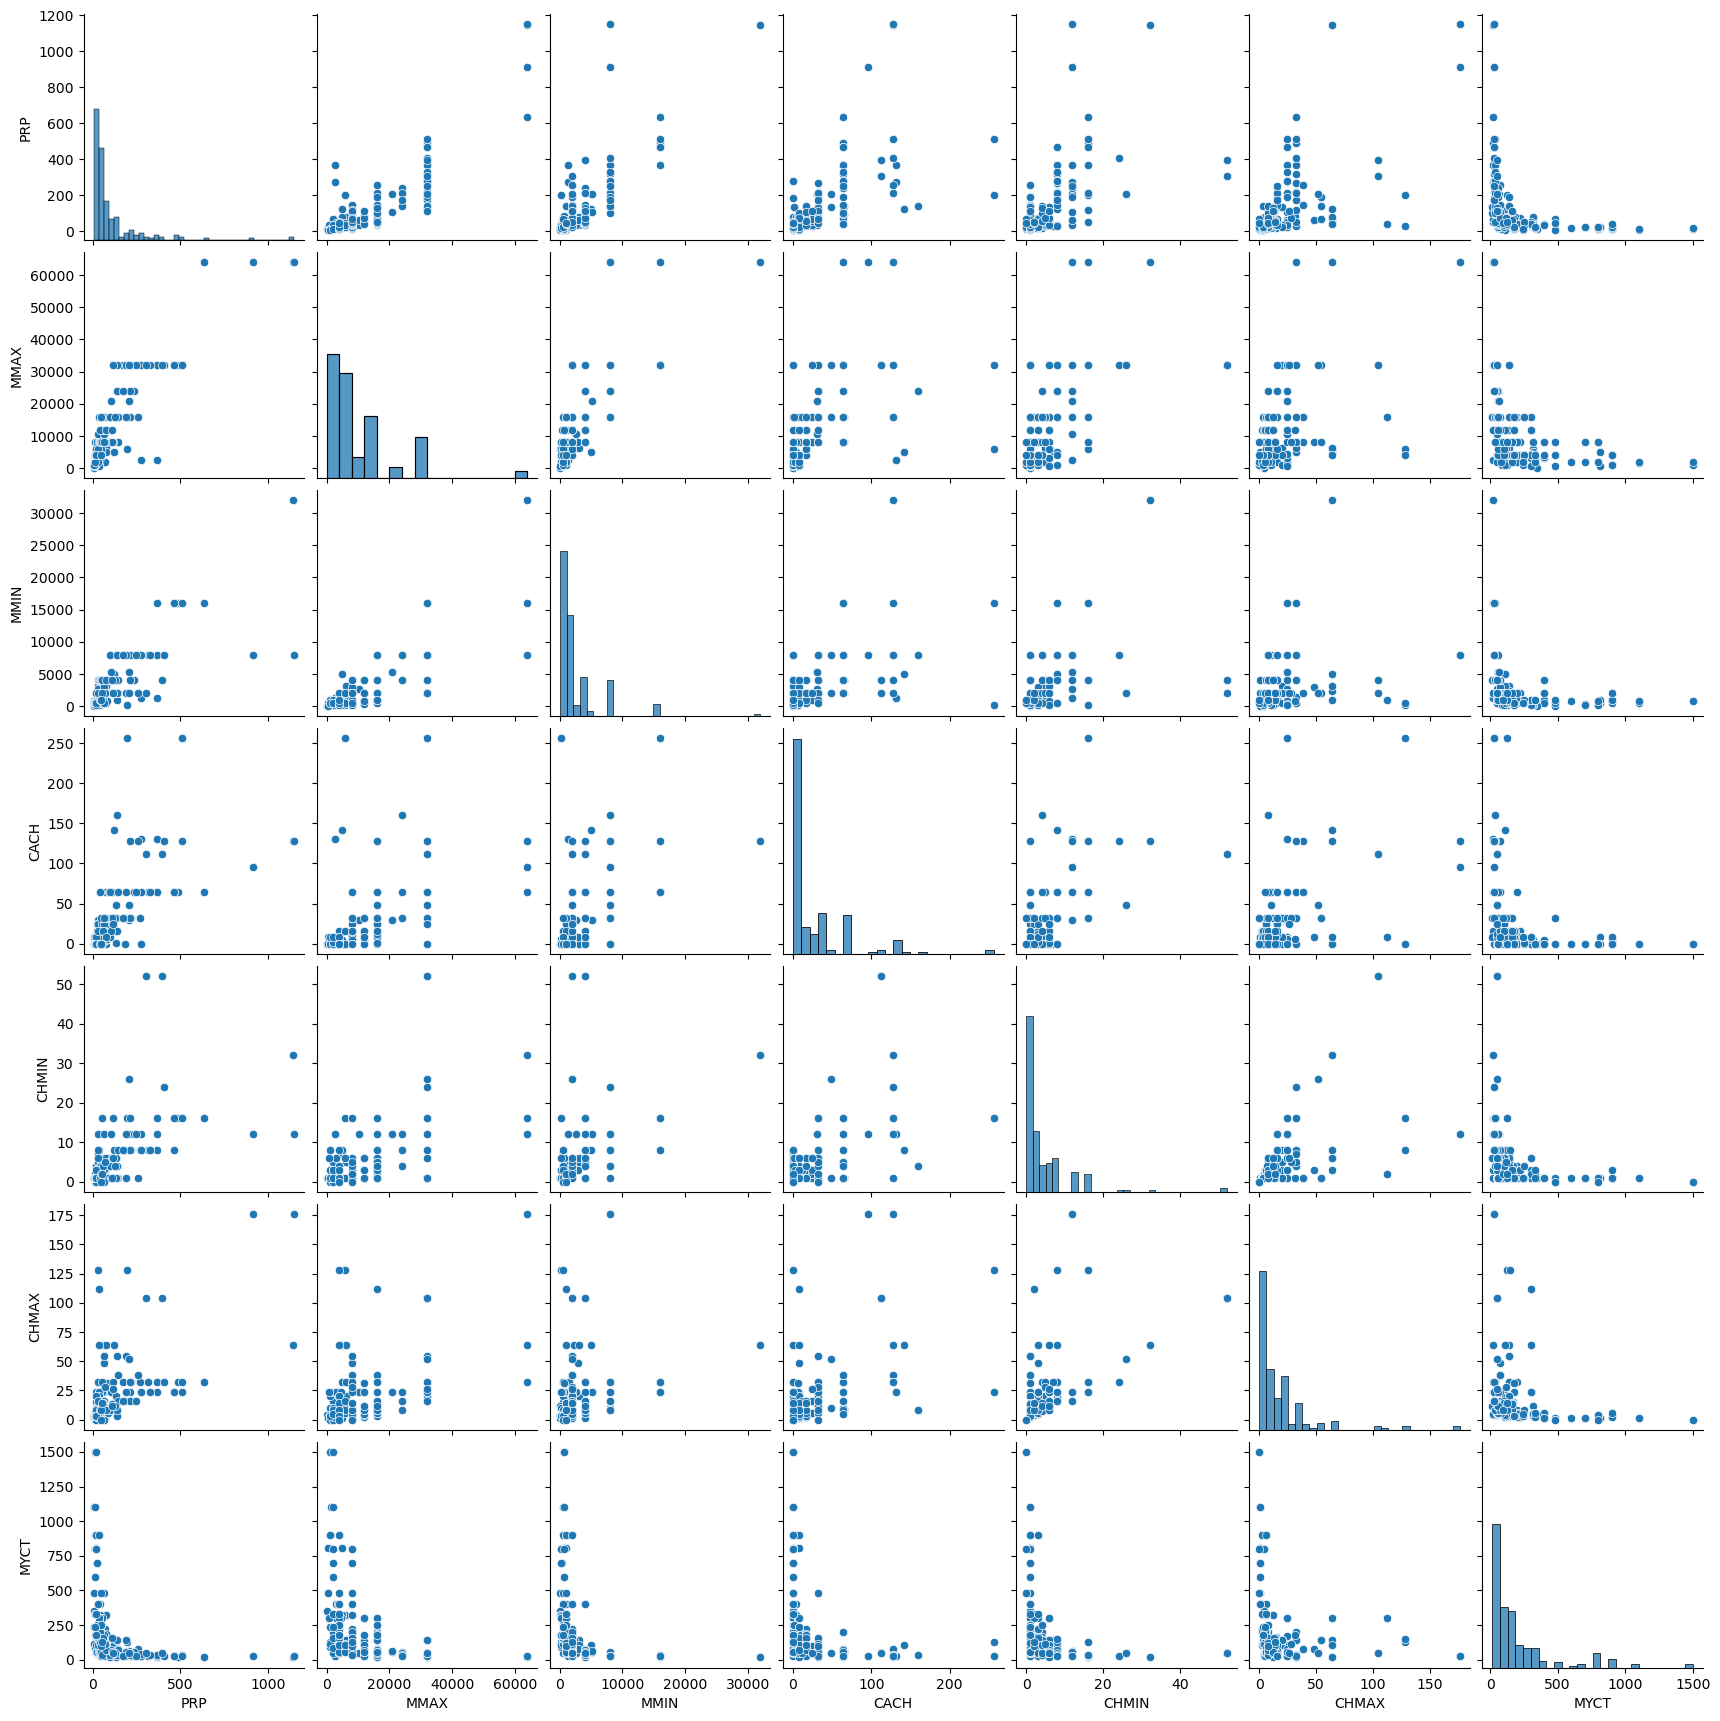

In [2]:
# 데이터 탐색 및 시각화 (데이터셋 업데이트)
machine_data = pd.read_csv('machine.data_update.csv')

print(machine_data.info())
print(machine_data.describe())
print(machine_data.head())
print(machine_data.shape)

# 범주형 데이터 수치화
dum = pd.get_dummies(machine_data.VendorName, prefix='v', dtype=float)
machine_data = pd.concat([machine_data.drop('VendorName', axis=1), dum], axis =1)
dum = pd.get_dummies(machine_data['ModelName'], prefix='m',  dtype=float)
machine_data = pd.concat([machine_data.drop('ModelName', axis=1), dum], axis =1)

# 데이터분포 시각화
result = machine_data.corr()['PRP']
result = np.abs(result).sort_values(ascending=False)
print(result)

# feature 선택
features = ['PRP', 'MMAX', 'MMIN', 'CACH', 'CHMIN', 'CHMAX', 'MYCT']
sns.pairplot(machine_data[features])
plt.show()


In [3]:
# X, y 설정
num_features = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'ERP']
X = machine_data[num_features]
y = machine_data['PRP']

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X.shape, y.shape

((209, 7), (209,))

In [4]:
# 앙상블 학습
# 1) 전처리 파이프라인 정의
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features)
    ]
)

# 2) 개별 모델 정의
models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor(random_state=42)),
    ('ridge', Ridge(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
]

# 3) 앙상블 모델 정의
ensemble = VotingRegressor(estimators=models)

# 4) 앙상블 모델 파이프라인 생성
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

# 5) 하이퍼파라미터 튜닝
params_grid = {
    'ensemble__sgd__alpha': [0.001, 0.01],
    'ensemble__sgd__max_iter': [1000, 2000],
    'ensemble__ridge__alpha': [10, 20],
    'ensemble__gbr__n_estimators': [100, 200], 
    'ensemble__gbr__learning_rate': [0.01, 0.1]
}
# 6) GridSearchCV 모델 설정 및 학습 및 성능 평가
grid_search_mse = GridSearchCV(model_pipeline, params_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
# grid_search_mae = GridSearchCV(model_pipeline, params_grid, cv = 5, scoring='neg_mean_absolute_error' , return_train_score=True )
# grid_search_r2 = GridSearchCV(model_pipeline, params_grid, cv = 5, scoring='r2' , return_train_score=True )

grid_search_mse.fit(X_train, y_train)
# grid_search_mae.fit(X_train, y_train)
# grid_search_r2.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MYCT',
                                                                          'MMIN',
                                                                          'MMAX',
                                                                          'CACH',
                                                                          'CHMIN',
                                                                          'CHMAX',
                                                                          'ERP'])])),
                                       ('ensemble',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('sgd',
                                                                     SGDRegressor(random_state=42)),
                                                                    ('ridge',
                                                                     Ridge(random_state=42)),
                                                                    ('gbr',
                                                                     GradientBoostingRegressor(random_state=42))]))]),
             param_grid={'ensemble__gbr__learning_rate': [0.01, 0.1],
                         'ensemble__gbr__n_estimators': [100, 200],
                         'ensemble__ridge__alpha': [10, 20],
                         'ensemble__sgd__alpha': [0.001, 0.01],
                         'ensemble__sgd__max_iter': [1000, 2000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [5]:
# 최적 파라미터 출력
print(f'Best parameters for MSE: {grid_search_mse.best_params_}\n')
# print(f'Best parameters for MAE: {grid_search_mae.best_params_}\n')
# print(f'Best parameters for R2: {grid_search_r2.best_params_}')

# 최적 모델 출력
best_model_mse = grid_search_mse.best_estimator_
# best_model_mae = grid_search_mae.best_estimator_
# best_model_r2 = grid_search_r2.best_estimator_

# 최적 모델로 예측
y_train_pred = best_model_mse.predict(X_train)
y_test_pred = best_model_mse.predict(X_test)


Best parameters for MSE: {'ensemble__gbr__learning_rate': 0.1, 'ensemble__gbr__n_estimators': 200, 'ensemble__ridge__alpha': 10, 'ensemble__sgd__alpha': 0.001, 'ensemble__sgd__max_iter': 1000}



/Users/seein/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


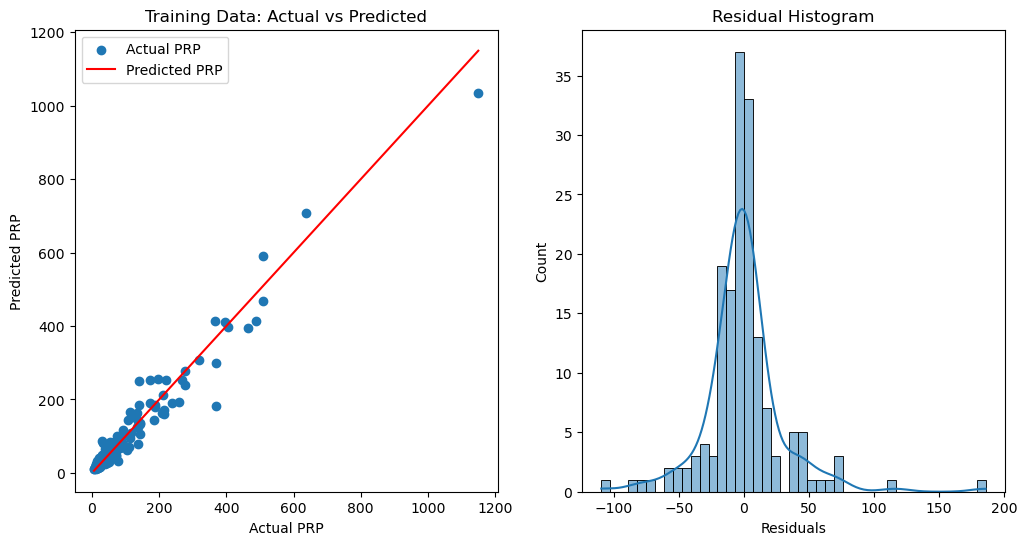

In [6]:
# 실제 데이터와 예측 데이터 비교 (학습 데이터)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, label='Actual PRP')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', label='Predicted PRP')
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Training Data: Actual vs Predicted')
plt.legend()


residuals = y_train - y_train_pred
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Residual Histogram')
plt.show()

/Users/seein/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


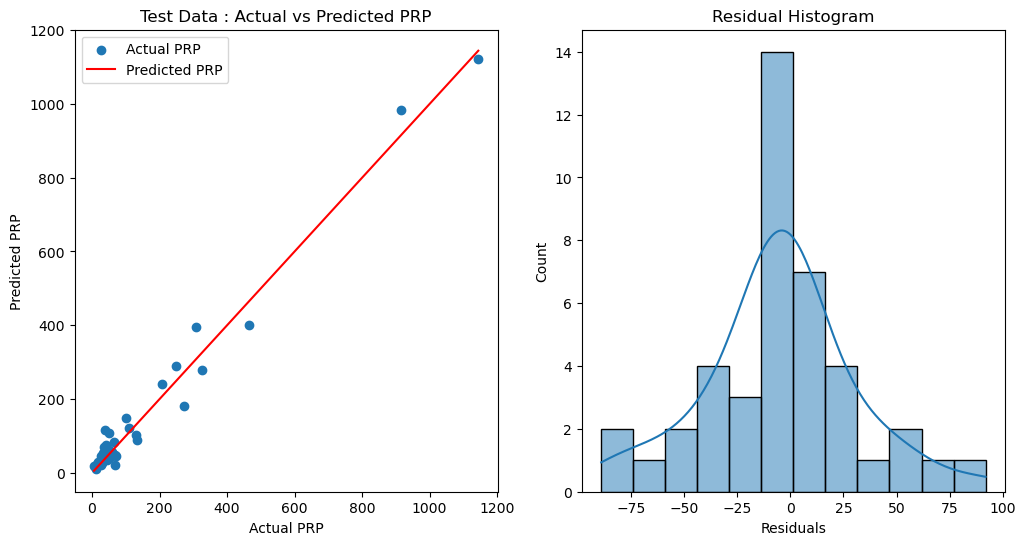

In [7]:
# 실제 데이터와 예측 데이터 비교 (테스트 데이터)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, label='Actual PRP')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Predicted PRP')
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Test Data : Actual vs Predicted PRP')
plt.legend()

residuals = y_test - y_test_pred
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Residual Histogram')
plt.show()

In [8]:
# 교차 검증
cv_scores = cross_val_score(grid_search_mse, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
cv_mse_train = -cv_scores.mean()
cv_scores = cross_val_score(grid_search_mse,X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')
cv_mae_train = -cv_scores.mean()
cv_scores = cross_val_score(grid_search_mse, X_train, y_train, cv = 5, scoring = 'r2')
cv_r2_train = cv_scores.mean()
print(f'<교차 검증>\nCorss-Validation MSE : {cv_mse_train}\nCorss-Validation MAE : {cv_mae_train}\nCorss-Validation r2 : {cv_r2_train}')


<교차 검증>
Corss-Validation MSE : 2953.1204942906797
Corss-Validation MAE : 27.01293801864635
Corss-Validation r2 : 0.837910718330782


In [9]:
# Best_estimator 모델 성능 테스트 (학습 데이터)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print(f'<훈련 데이터 성능>\nMSE = {mse_train}\nMAE = {mae_train}\nR2 = {r2_train}')

# Best_estimator 모델 성능 테스트 (테스트 데이터)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'<테스트 데이터 성능>\nMSE = {mse_test}\nMAE = {mae_test}\nR2 = {r2_test}')

<훈련 데이터 성능>
MSE = 957.9569452587741
MAE = 18.53260972655524
R2 = 0.9501698672617603
<테스트 데이터 성능>
MSE = 1261.5198460973068
MAE = 25.271923432914832
R2 = 0.9752190566215029


In [10]:
# LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred_lr = model.predict(X_train)
y_test_pred_lr = model.predict(X_test)

# Linear Regression 모델 성능 테스트 (학습 데이터)
mse_train_lr = mean_squared_error(y_train, y_train_pred_lr)
mae_train_lr = mean_absolute_error(y_train, y_train_pred_lr)
r2_train_lr = r2_score(y_train, y_train_pred_lr)
# Linear Regression 모델 성능 테스트 (테스트 데이터)
mse_test_lr = mean_squared_error(y_test, y_test_pred_lr)
mae_test_lr = mean_absolute_error(y_test, y_test_pred_lr)
r2_test_lr = r2_score(y_test, y_test_pred_lr)
# Linear Regression 모델 교차 검증
cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
cv_mse_train_lr = -cv_scores.mean()
cv_scores = cross_val_score(model,X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')
cv_mae_train_lr = -cv_scores.mean()
cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'r2')
cv_r2_train_lr = cv_scores.mean()

In [11]:
# 데이터프레임 저장
machine_result = {
    'Model': ['Linear Regression', 'Linear Regression', 'Best_estimator', 'Best_estimator', 'Linear Regression', 'Best_estimator'],
    'Data': ['Train', 'Test', 'Train', 'Test', 'Cross Validation', 'Cross Validation'],
    'MSE': [mse_train_lr, mse_test_lr, mse_train, mse_test, cv_mse_train_lr, cv_mse_train],
    'MAE': [mae_train_lr, mae_test_lr, mae_train, mae_test, cv_mae_train_lr, cv_mae_train],
    'R^2': [r2_train_lr, r2_test_lr, r2_train, r2_test, cv_r2_train_lr, cv_r2_train]
}
machine_data_df = pd.DataFrame(machine_result)
machine_data_df

,Model,Data,MSE,MAE,R^2
0,Linear Regression,Train,1529.020471,23.232256,0.920465
1,Linear Regression,Test,2370.096375,31.406219,0.953442
2,Best_estimator,Train,957.956945,18.532610,0.950170
3,Best_estimator,Test,1261.519846,25.271923,0.975219
4,Linear Regression,Cross Validation,2611.435767,27.519659,0.847991
5,Best_estimator,Cross Validation,2953.120494,27.012938,0.837911


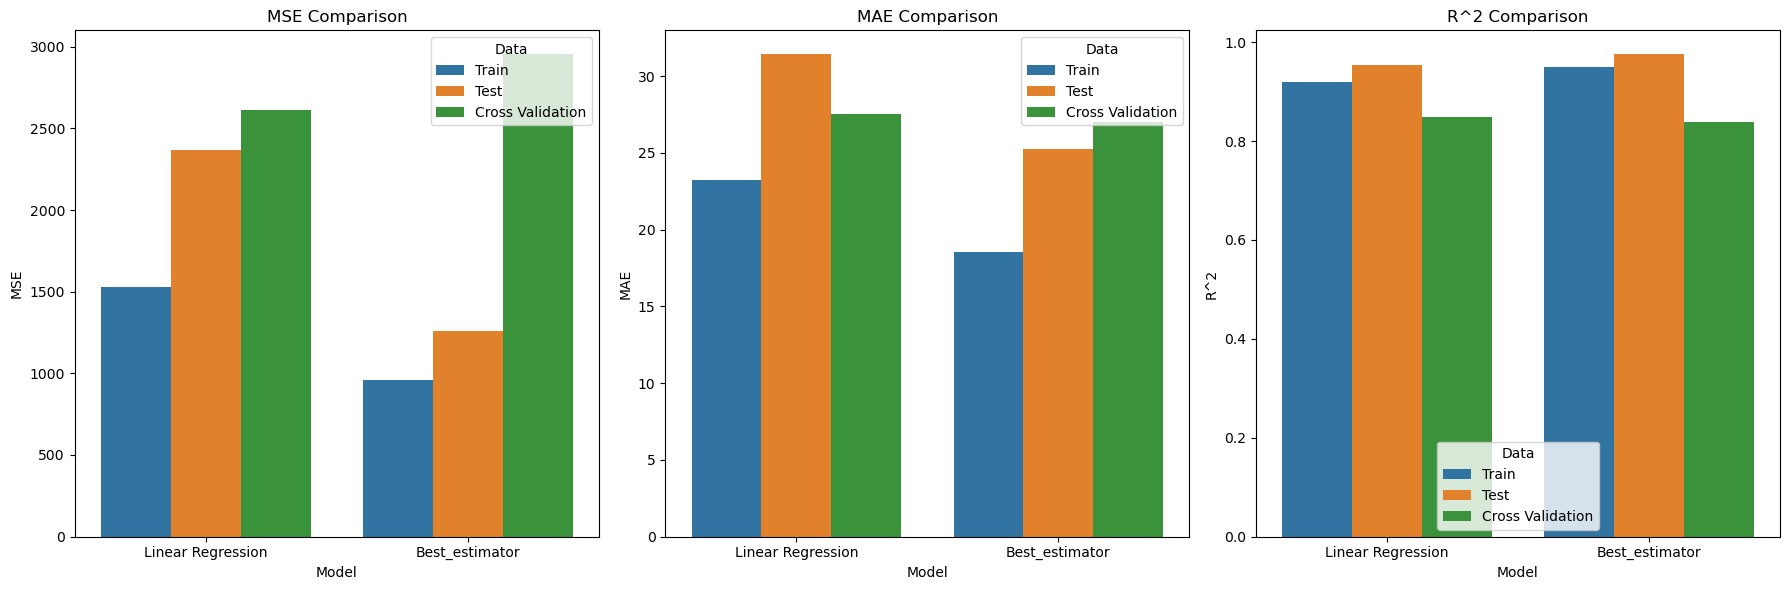

In [12]:
# 그래프 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(data=machine_data_df, x='Model', y='MSE', hue='Data', ax=axes[0])
axes[0].set_title('MSE Comparison')

sns.barplot(data=machine_data_df, x='Model', y='MAE', hue='Data', ax=axes[1])
axes[1].set_title('MAE Comparison')

sns.barplot(data=machine_data_df, x='Model', y='R^2', hue='Data', ax=axes[2])
axes[2].set_title('R^2 Comparison')

plt.tight_layout()
plt.show()
